# Análisis Exploratorio - Datos Unificados de Polígonos

Este notebook realiza un análisis exploratorio completo del dataset unificado incluyendo:
- Análisis de datos faltantes
- Detección de anomalías con múltiples técnicas
- Visualización de relaciones entre variables
- Análisis de correlación

## 1. Importar Librerías y Cargar Datos

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Cargar datos
project_root = Path.cwd().parent
data_path = project_root / 'data' / 'processed' / 'unificado' / 'poligonos_unificados_completo.csv'

print(f"Cargando datos desde: {data_path}")
df = pd.read_csv(data_path)

print(f"\n✓ Dataset cargado exitosamente")
print(f"  Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()

Cargando datos desde: c:\Users\joel_\indice-delictivo-hermosillo\data\processed\unificado\poligonos_unificados_completo.csv

✓ Dataset cargado exitosamente
  Dimensiones: 700 filas × 30 columnas

Primeras filas:


,cve_ent,cve_mun,cve_loc,nom_loc,CVE_COL,COLONIA,CP,otros_cp,total_incidentes,incidentes_alta,...,viviendas_totales,escolaridad_años_prom,pctj_menores18,pctj_hombres,pctj_mujeres,tasa_incidentes_per_1k,tasa_alta_severidad_per_1k,score_severidad,area_km2,densidad_poblacional
0,26,30,1,Hermosillo,2603000016735,ALTA FIRENZE NORTE RESIDENCIAL,83104.0,NaN,1,1,...,68.0,14.9,28.6%,49.4%,50.6%,12.987013,12.987013,3.000000,0.037555,2050.340413
1,26,30,1,Hermosillo,2603000011785,JORGE VALDEZ MUÃOZ,83104.0,NaN,3066,1404,...,366.0,9.4,35.7%,49.9%,50.1%,2836.262720,1298.797410,2.199609,0.108585,9955.346547
2,26,30,1,Hermosillo,2603000016335,VILLA VERDE CERRADA SAN VICENTE,83118.0,NaN,0,0,...,261.0,9.5,40.4%,52.4%,47.6%,0.000000,0.000000,0.000000,0.060584,11801.826946
3,26,30,1,Hermosillo,2603000011480,VILLA VENTURA,83159.0,NaN,0,0,...,86.0,14.2,21.7%,46.5%,53.5%,0.000000,0.000000,0.000000,0.017695,6781.506720
4,26,30,1,Hermosillo,2603000011663,NUEVO HERMOSILLO,83296.0,NaN,43729,15409,...,4102.0,10.7,29.4%,49.1%,50.9%,3462.586111,1220.128276,2.022754,1.266794,9969.263119


In [24]:
df.columns

Index(['cve_ent', 'cve_mun', 'cve_loc', 'nom_loc', 'CVE_COL', 'COLONIA', 'CP',
       'otros_cp', 'total_incidentes', 'incidentes_alta', 'incidentes_media',
       'incidentes_baja', 'categorias_dict', 'partes_dia_dict',
       'incidentes_fin_semana', 'incidentes_quincena', 'dias_semana_dict',
       'fecha_inicio', 'fecha_fin', 'poblacion_total', 'viviendas_totales',
       'escolaridad_años_prom', 'pctj_menores18', 'pctj_hombres',
       'pctj_mujeres', 'tasa_incidentes_per_1k', 'tasa_alta_severidad_per_1k',
       'score_severidad', 'area_km2', 'densidad_poblacional'],
      dtype='object')

### Información General del Dataset

In [21]:
# Información general
print("="*70)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*70)
print(f"\nTipo de datos:\n")
print(df.dtypes)
print(f"\nEstadísticas descriptivas:\n")
df.describe().T

INFORMACIÓN GENERAL DEL DATASET

Tipo de datos:

cve_ent                         int64
cve_mun                         int64
cve_loc                         int64
nom_loc                        object
CVE_COL                         int64
COLONIA                        object
CP                            float64
otros_cp                      float64
total_incidentes                int64
incidentes_alta                 int64
incidentes_media                int64
incidentes_baja                 int64
categorias_dict                object
partes_dia_dict                object
incidentes_fin_semana           int64
incidentes_quincena             int64
dias_semana_dict               object
fecha_inicio                   object
fecha_fin                      object
poblacion_total               float64
viviendas_totales             float64
escolaridad_años_prom         float64
pctj_menores18                 object
pctj_hombres                   object
pctj_mujeres                   object
t

,count,mean,std,min,25%,50%,75%,max
cve_ent,700.0,2.600000e+01,0.000000e+00,2.600000e+01,2.600000e+01,2.600000e+01,2.600000e+01,2.600000e+01
cve_mun,700.0,3.000000e+01,0.000000e+00,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01
cve_loc,700.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CVE_COL,700.0,2.599285e+12,9.828577e+10,2.603000e+09,2.603000e+12,2.603000e+12,2.603000e+12,2.603000e+12
CP,700.0,8.317611e+04,7.703609e+01,8.300000e+04,8.311400e+04,8.315900e+04,8.324525e+04,8.334400e+04
otros_cp,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_incidentes,700.0,2.381034e+03,6.588273e+03,0.000000e+00,0.000000e+00,1.325000e+02,1.781500e+03,8.050800e+04
incidentes_alta,700.0,8.260814e+02,2.250613e+03,0.000000e+00,0.000000e+00,3.850000e+01,5.395000e+02,2.403200e+04
incidentes_media,700.0,9.834557e+02,2.950511e+03,0.000000e+00,0.000000e+00,4.950000e+01,7.325000e+02,4.209400e+04
incidentes_baja,700.0,5.714971e+02,1.506167e+03,0.000000e+00,0.000000e+00,3.300000e+01,4.517500e+02,1.441400e+04


## 2. Análisis de Datos Faltantes

In [22]:
# Análisis de datos faltantes
print("="*70)
print("ANÁLISIS DE DATOS FALTANTES")
print("="*70)

# Contar valores nulos
missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Valores_Nulos': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df) * 100).round(2),
    'Tipo_Datos': df.dtypes
}).sort_values('Valores_Nulos', ascending=False)

missing_data = missing_data[missing_data['Valores_Nulos'] > 0]

if len(missing_data) == 0:
    print("\n✓ No hay datos faltantes en el dataset")
else:
    print(f"\n⚠️  Se encontraron {len(missing_data)} columnas con datos faltantes:\n")
    print(missing_data.to_string())

print(f"\nTotal de valores nulos: {df.isnull().sum().sum():,}")
print(f"Porcentaje total de valores nulos: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

ANÁLISIS DE DATOS FALTANTES

⚠️  Se encontraron 15 columnas con datos faltantes:

                                               Columna  Valores_Nulos  Porcentaje Tipo_Datos
otros_cp                                      otros_cp            700      100.00    float64
dias_semana_dict                      dias_semana_dict            230       32.86     object
fecha_inicio                              fecha_inicio            230       32.86     object
fecha_fin                                    fecha_fin            230       32.86     object
partes_dia_dict                        partes_dia_dict            230       32.86     object
categorias_dict                        categorias_dict            230       32.86     object
escolaridad_años_prom            escolaridad_años_prom             58        8.29    float64
pctj_menores18                          pctj_menores18             58        8.29     object
pctj_hombres                              pctj_hombres             58        8.29

### Visualización de Datos Faltantes

In [25]:
# Visualizar datos faltantes
if df.isnull().sum().sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras - Valores nulos por columna
    missing_counts = df.isnull().sum()-
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    missing_counts.plot(kind='barh', ax=axes[0], color='coral')
    axes[0].set_xlabel('Cantidad de Valores Nulos')
    axes[0].set_title('Valores Nulos por Columna', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Gráfico circular - Porcentaje de cobertura
    coverage = (1 - df.isnull().sum() / len(df)) * 100
    coverage_values = [coverage[coverage < 100].sum(), (100 - coverage[coverage < 100].sum())]
    colors = ['#2ecc71', '#e74c3c']
    axes[1].pie([coverage.sum() / len(coverage), 100 - coverage.sum() / len(coverage)], 
                labels=['Completo', 'Con Faltantes'], 
                autopct='%1.1f%%',
                colors=colors,
                startangle=90)
    axes[1].set_title('Cobertura General del Dataset', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos faltantes para visualizar")

SyntaxError: invalid syntax (313445372.py, line 6)

## 3. Detección de Anomalías - Métodos Estadísticos (Z-Score e IQR)

In [5]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR")
print("="*70)

# Z-Score
print("\n[1] Z-SCORE METHOD:")
print("-" * 70)

z_scores = np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean())))
outliers_zscore = (z_scores > 3).sum()

print(f"\nOultiers detectados con |z-score| > 3:")
outlier_cols = outliers_zscore[outliers_zscore > 0].sort_values(ascending=False)

if len(outlier_cols) > 0:
    for col, count in outlier_cols.items():
        pct = (count / len(df)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con z-score > 3")

print(f"\nTotal de outliers detectados (Z-Score): {outliers_zscore.sum():,}")

DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR

[1] Z-SCORE METHOD:
----------------------------------------------------------------------

Oultiers detectados con |z-score| > 3:
  • incidentes_alta: 18 (2.57%)
  • incidentes_baja: 16 (2.29%)
  • poblacion_total: 15 (2.14%)
  • viviendas_totales: 15 (2.14%)
  • total_incidentes: 13 (1.86%)
  • incidentes_media: 12 (1.71%)
  • area_km2: 11 (1.57%)
  • densidad_poblacional: 7 (1.00%)
  • escolaridad_años_prom: 3 (0.43%)
  • CVE_COL: 1 (0.14%)
  • tasa_incidentes_per_1k: 1 (0.14%)
  • tasa_alta_severidad_per_1k: 1 (0.14%)

Total de outliers detectados (Z-Score): 113


In [6]:
# IQR Method
print("\n[2] INTERQUARTILE RANGE (IQR) METHOD:")
print("-" * 70)

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()

print(f"\nOultiers detectados fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]:")
outlier_cols_iqr = outliers_iqr[outliers_iqr > 0].sort_values(ascending=False)

if len(outlier_cols_iqr) > 0:
    for col, count in outlier_cols_iqr.items():
        pct = (count / len(df)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con método IQR")

print(f"\nTotal de outliers detectados (IQR): {outliers_iqr.sum():,}")


[2] INTERQUARTILE RANGE (IQR) METHOD:
----------------------------------------------------------------------

Oultiers detectados fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]:
  • incidentes_alta: 107 (15.29%)
  • total_incidentes: 99 (14.14%)
  • incidentes_baja: 94 (13.43%)
  • incidentes_media: 92 (13.14%)
  • area_km2: 75 (10.71%)
  • poblacion_total: 69 (9.86%)
  • viviendas_totales: 60 (8.57%)
  • tasa_incidentes_per_1k: 42 (6.00%)
  • tasa_alta_severidad_per_1k: 38 (5.43%)
  • densidad_poblacional: 9 (1.29%)
  • escolaridad_años_prom: 2 (0.29%)
  • CVE_COL: 1 (0.14%)

Total de outliers detectados (IQR): 688


### Visualización de Outliers - Métodos Estadísticos

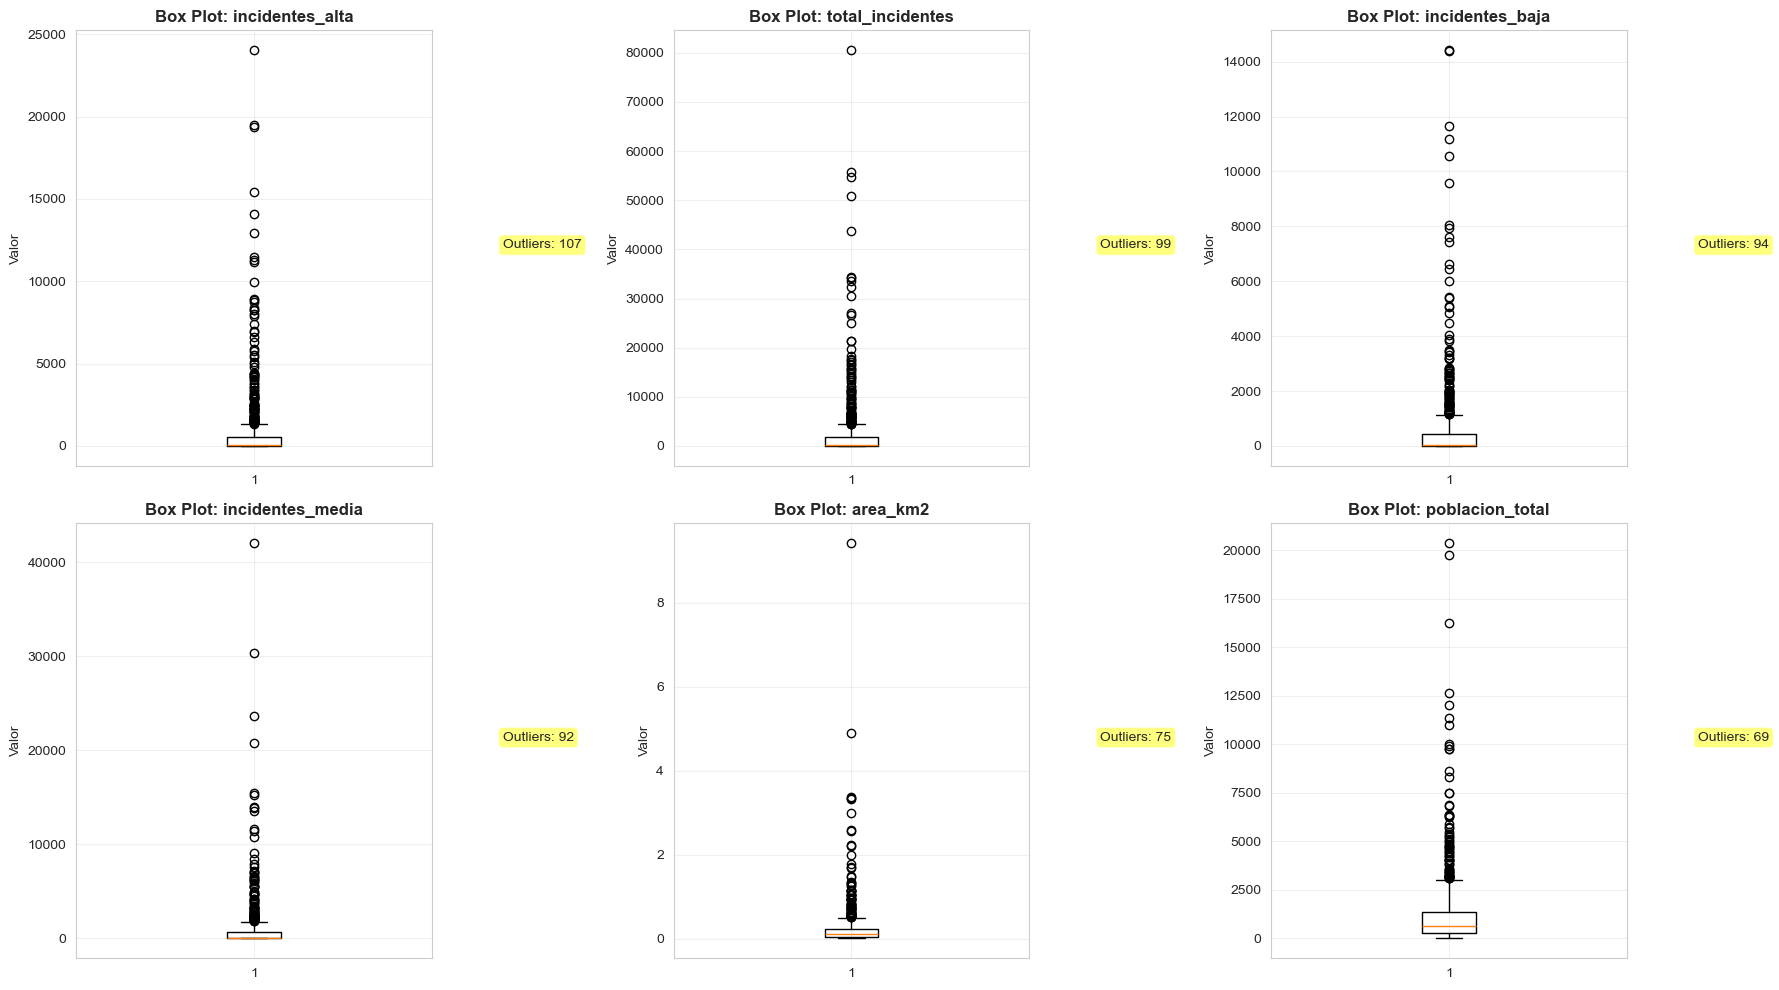


Visualización: Box plots de las columnas con más outliers detectados


In [7]:
# Visualizar outliers con Box Plots
top_cols = outlier_cols_iqr.head(6).index.tolist() if len(outlier_cols_iqr) > 0 else numeric_cols[:6]

if len(top_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(top_cols):
        # Box plot
        axes[idx].boxplot(df_numeric[col].dropna(), vert=True)
        axes[idx].set_title(f'Box Plot: {col}', fontweight='bold')
        axes[idx].set_ylabel('Valor')
        axes[idx].grid(alpha=0.3)
        
        # Detectar outliers
        Q1 = df_numeric[col].quantile(0.25)
        Q3 = df_numeric[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_numeric[col] < (Q1 - 1.5*IQR)) | (df_numeric[col] > (Q3 + 1.5*IQR))
        n_outliers = outlier_mask.sum()
        
        axes[idx].text(1.2, 0.5, f'Outliers: {n_outliers}', 
                      transform=axes[idx].transAxes, fontsize=10,
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    print(f"\nVisualización: Box plots de las columnas con más outliers detectados")

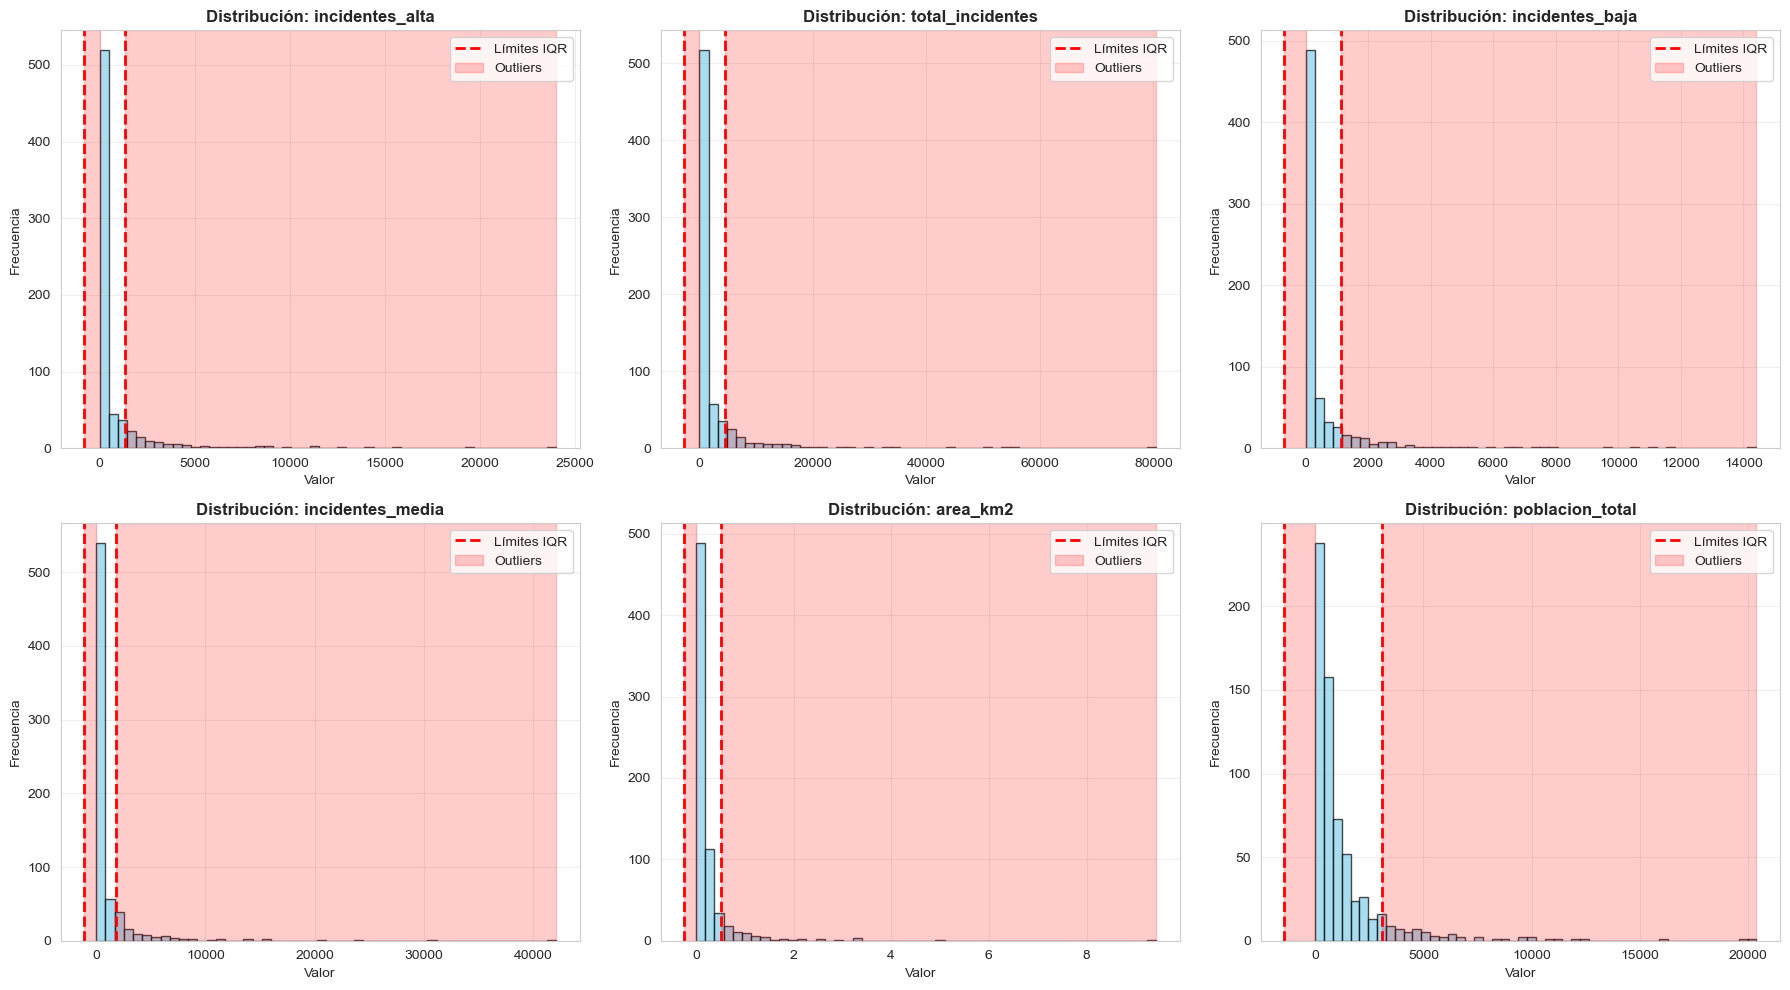


Visualización: Histogramas con región de outliers marcada en rojo


In [8]:
# Histogramas con región de outliers marcada
if len(top_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(top_cols):
        data = df_numeric[col].dropna()
        
        # Calcular límites
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        # Histograma
        axes[idx].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Marcar región de outliers
        axes[idx].axvline(lower_bound, color='red', linestyle='--', linewidth=2, label='Límites IQR')
        axes[idx].axvline(upper_bound, color='red', linestyle='--', linewidth=2)
        axes[idx].axvspan(data.min(), lower_bound, alpha=0.2, color='red', label='Outliers')
        axes[idx].axvspan(upper_bound, data.max(), alpha=0.2, color='red')
        
        axes[idx].set_title(f'Distribución: {col}', fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"\nVisualización: Histogramas con región de outliers marcada en rojo")

## 4. Detección de Anomalías - Método 2: Isolation Forest

In [9]:
print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 2: ISOLATION FOREST")
print("="*70)

# Preparar datos para Isolation Forest
df_clean = df_numeric.fillna(df_numeric.mean())
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Aplicar Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
outlier_predictions = iso_forest.fit_predict(df_scaled)
anomaly_scores = iso_forest.score_samples(df_scaled)

# Contar anomalías
n_anomalies = (outlier_predictions == -1).sum()
anomaly_pct = (n_anomalies / len(df)) * 100

print(f"\nAnomalías detectadas por Isolation Forest:")
print(f"  • Total de anomalías: {n_anomalies:,} ({anomaly_pct:.2f}%)")
print(f"  • Registros normales: {(outlier_predictions == 1).sum():,} ({100-anomaly_pct:.2f}%)")

# Agregar predicciones al dataframe
df['anomaly_isolation_forest'] = outlier_predictions
df['anomaly_score'] = anomaly_scores

# Mostrar anomalías más extremas
print(f"\nTop 10 anomalías más extremas (anomaly score más bajo):")
top_anomalies = df[df['anomaly_isolation_forest'] == -1].nsmallest(10, 'anomaly_score')
if len(top_anomalies) > 0:
    display(top_anomalies[['COLONIA', 'anomaly_score'] + numeric_cols[:5]])
else:
    print("No se encontraron anomalías")

DETECCIÓN DE ANOMALÍAS - MÉTODO 2: ISOLATION FOREST

Anomalías detectadas por Isolation Forest:
  • Total de anomalías: 35 (5.00%)
  • Registros normales: 665 (95.00%)

Top 10 anomalías más extremas (anomaly score más bajo):


,COLONIA,anomaly_score,cve_ent,cve_mun,cve_loc,CVE_COL,CP
190,CENTRO,-0.717188,26,30,1,2603000011484,83000.0
487,SOLIDARIDAD,-0.680158,26,30,1,2603000011374,83116.0
562,PALO VERDE,-0.680112,26,30,1,2603000011815,83280.0
107,ALTARES,-0.674497,26,30,1,2603000011589,83294.0
4,NUEVO HERMOSILLO,-0.673416,26,30,1,2603000011663,83296.0
349,PARQUE INDUSTRIAL,-0.670440,26,30,1,2603000011665,83299.0
602,SAN BENITO,-0.669185,26,30,1,2603000011602,83190.0
374,VILLA DE SERIS,-0.629706,26,30,1,2603000011684,83280.0
644,CENTENARIO,-0.627003,26,30,1,2603000011558,83260.0
64,BALDERRAMA,-0.625163,26,30,1,2603000011473,83180.0


### Visualización de Anomalías - Isolation Forest

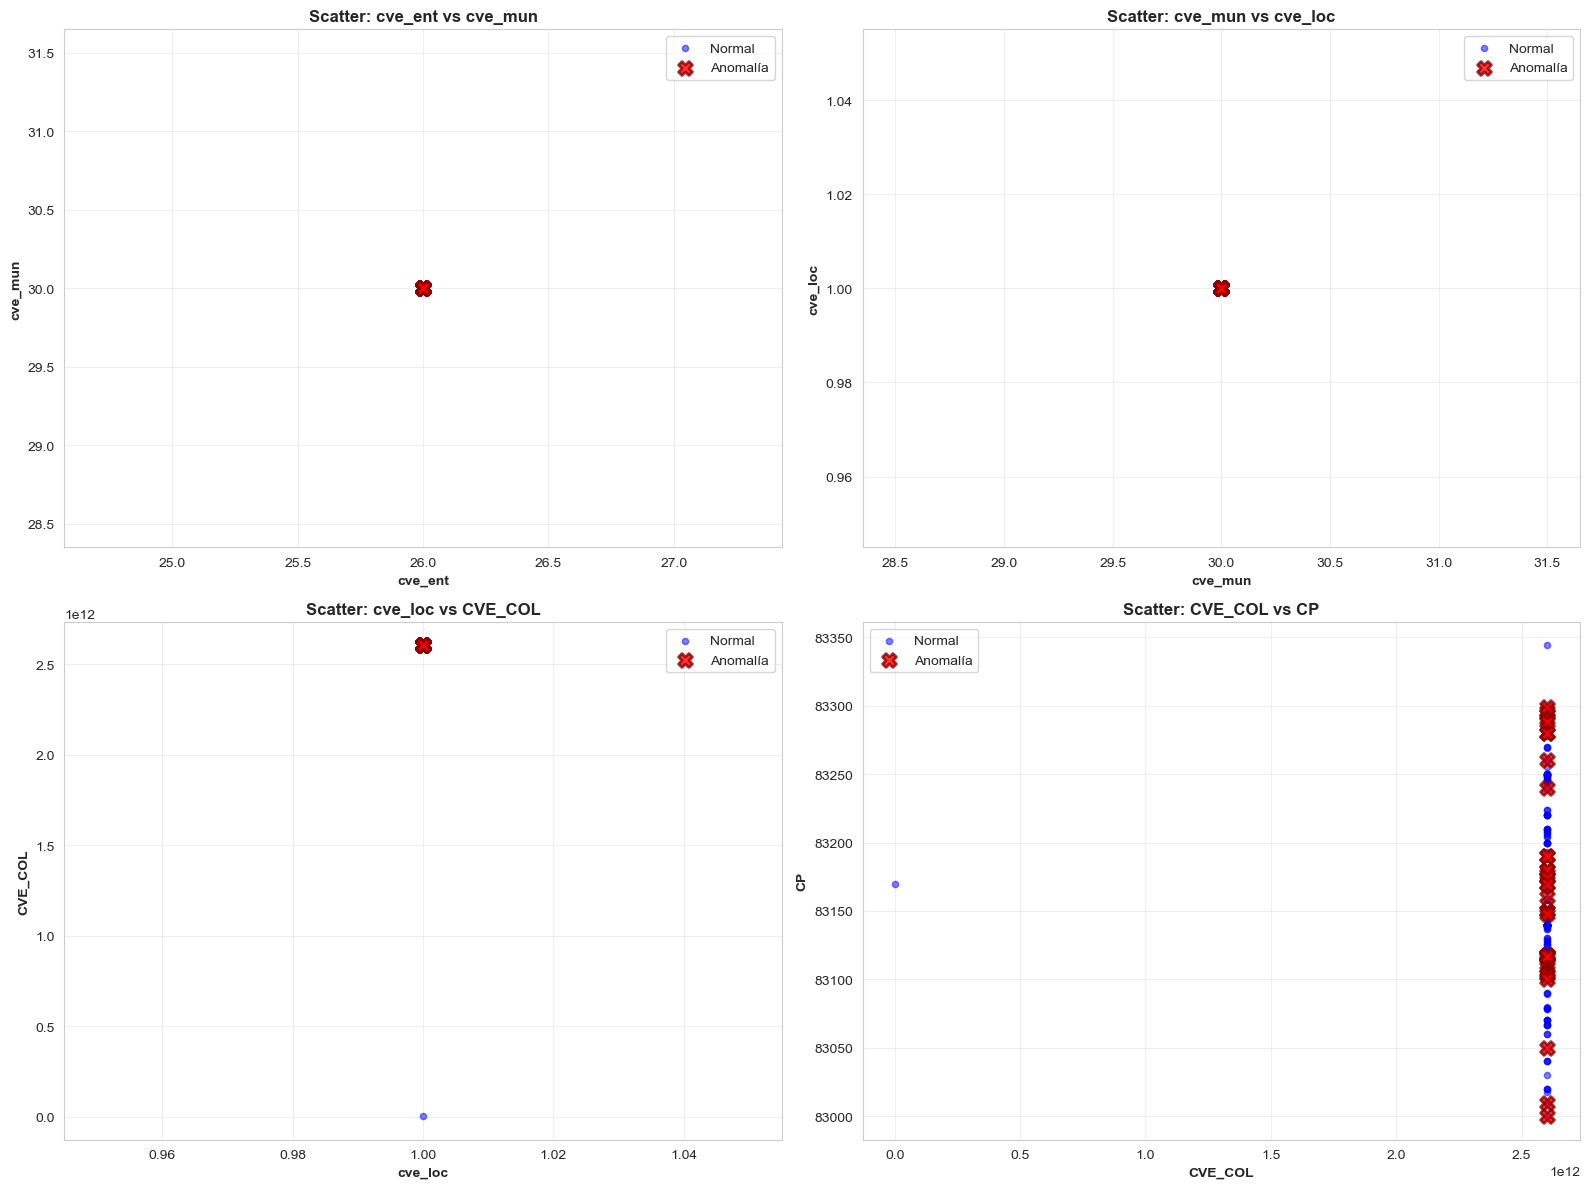


Visualización: Anomalías detectadas por Isolation Forest (marcadas en rojo)


In [10]:
# Scatter plots de anomalías
if len(numeric_cols) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Combinaciones de columnas para visualizar
    col_pairs = [
        (numeric_cols[0], numeric_cols[1]),
        (numeric_cols[1], numeric_cols[2]) if len(numeric_cols) > 2 else (numeric_cols[0], numeric_cols[1]),
        (numeric_cols[2], numeric_cols[3]) if len(numeric_cols) > 3 else (numeric_cols[0], numeric_cols[1]),
        (numeric_cols[3], numeric_cols[4]) if len(numeric_cols) > 4 else (numeric_cols[0], numeric_cols[1])
    ]
    
    for idx, (ax, (col1, col2)) in enumerate(zip(axes.ravel(), col_pairs)):
        # Puntos normales
        normal_mask = df['anomaly_isolation_forest'] == 1
        ax.scatter(df_numeric[normal_mask][col1], df_numeric[normal_mask][col2], 
                  alpha=0.5, s=20, c='blue', label='Normal')
        
        # Anomalías
        anomaly_mask = df['anomaly_isolation_forest'] == -1
        ax.scatter(df_numeric[anomaly_mask][col1], df_numeric[anomaly_mask][col2], 
                  alpha=0.8, s=100, c='red', marker='X', label='Anomalía', edgecolors='darkred', linewidth=2)
        
        ax.set_xlabel(col1, fontweight='bold')
        ax.set_ylabel(col2, fontweight='bold')
        ax.set_title(f'Scatter: {col1} vs {col2}', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"\nVisualización: Anomalías detectadas por Isolation Forest (marcadas en rojo)")

In [ ]:
# PCA 2D para visualizar anomalías en espacio reducido
if len(df_scaled[0]) > 1:
    # Reemplazar NaNs columna a columna (columnas totalmente NaN -> 0)
    X_for_pca = df_scaled.copy()
    nan_mask = np.isnan(X_for_pca)
    if nan_mask.any():
        col_means = np.nanmean(X_for_pca, axis=0)
        col_means = np.where(np.isnan(col_means), 0, col_means)
        rows, cols = np.where(nan_mask)
        X_for_pca[rows, cols] = col_means[cols]
        print(f"✓ NaNs imputados para PCA (columnas con todos NaN reemplazadas por 0).")
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_for_pca)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Puntos normales
    normal_mask = df['anomaly_isolation_forest'] == 1
    ax.scatter(pca_transformed[normal_mask, 0], pca_transformed[normal_mask, 1], 
               alpha=0.5, s=30, c='blue', label='Normal')
    
    # Anomalías
    anomaly_mask = df['anomaly_isolation_forest'] == -1
    ax.scatter(pca_transformed[anomaly_mask, 0], pca_transformed[anomaly_mask, 1], 
               alpha=0.8, s=150, c='red', marker='X', label='Anomalía', edgecolors='darkred', linewidth=2)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)', fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)', fontweight='bold')
    ax.set_title('Anomalías en Espacio PCA 2D', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVarianza explicada:")
    print(f"  • PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"  • PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"  • Total: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.2%}")

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 5. Visualización de Relaciones entre Variables

In [12]:
print("="*70)
print("ANÁLISIS DE RELACIONES ENTRE VARIABLES")
print("="*70)

# Seleccionar las 6-8 columnas numéricas más importantes
key_numeric_cols = numeric_cols[:8] if len(numeric_cols) >= 8 else numeric_cols

print(f"\nColumnas numéricas seleccionadas para análisis:")
for col in key_numeric_cols:
    print(f"  • {col}")

# Crear pair plot
print(f"\nGenerando Pair Plot (análisis de relaciones)...")

ANÁLISIS DE RELACIONES ENTRE VARIABLES

Columnas numéricas seleccionadas para análisis:
  • cve_ent
  • cve_mun
  • cve_loc
  • CVE_COL
  • CP
  • otros_cp
  • total_incidentes
  • incidentes_alta

Generando Pair Plot (análisis de relaciones)...


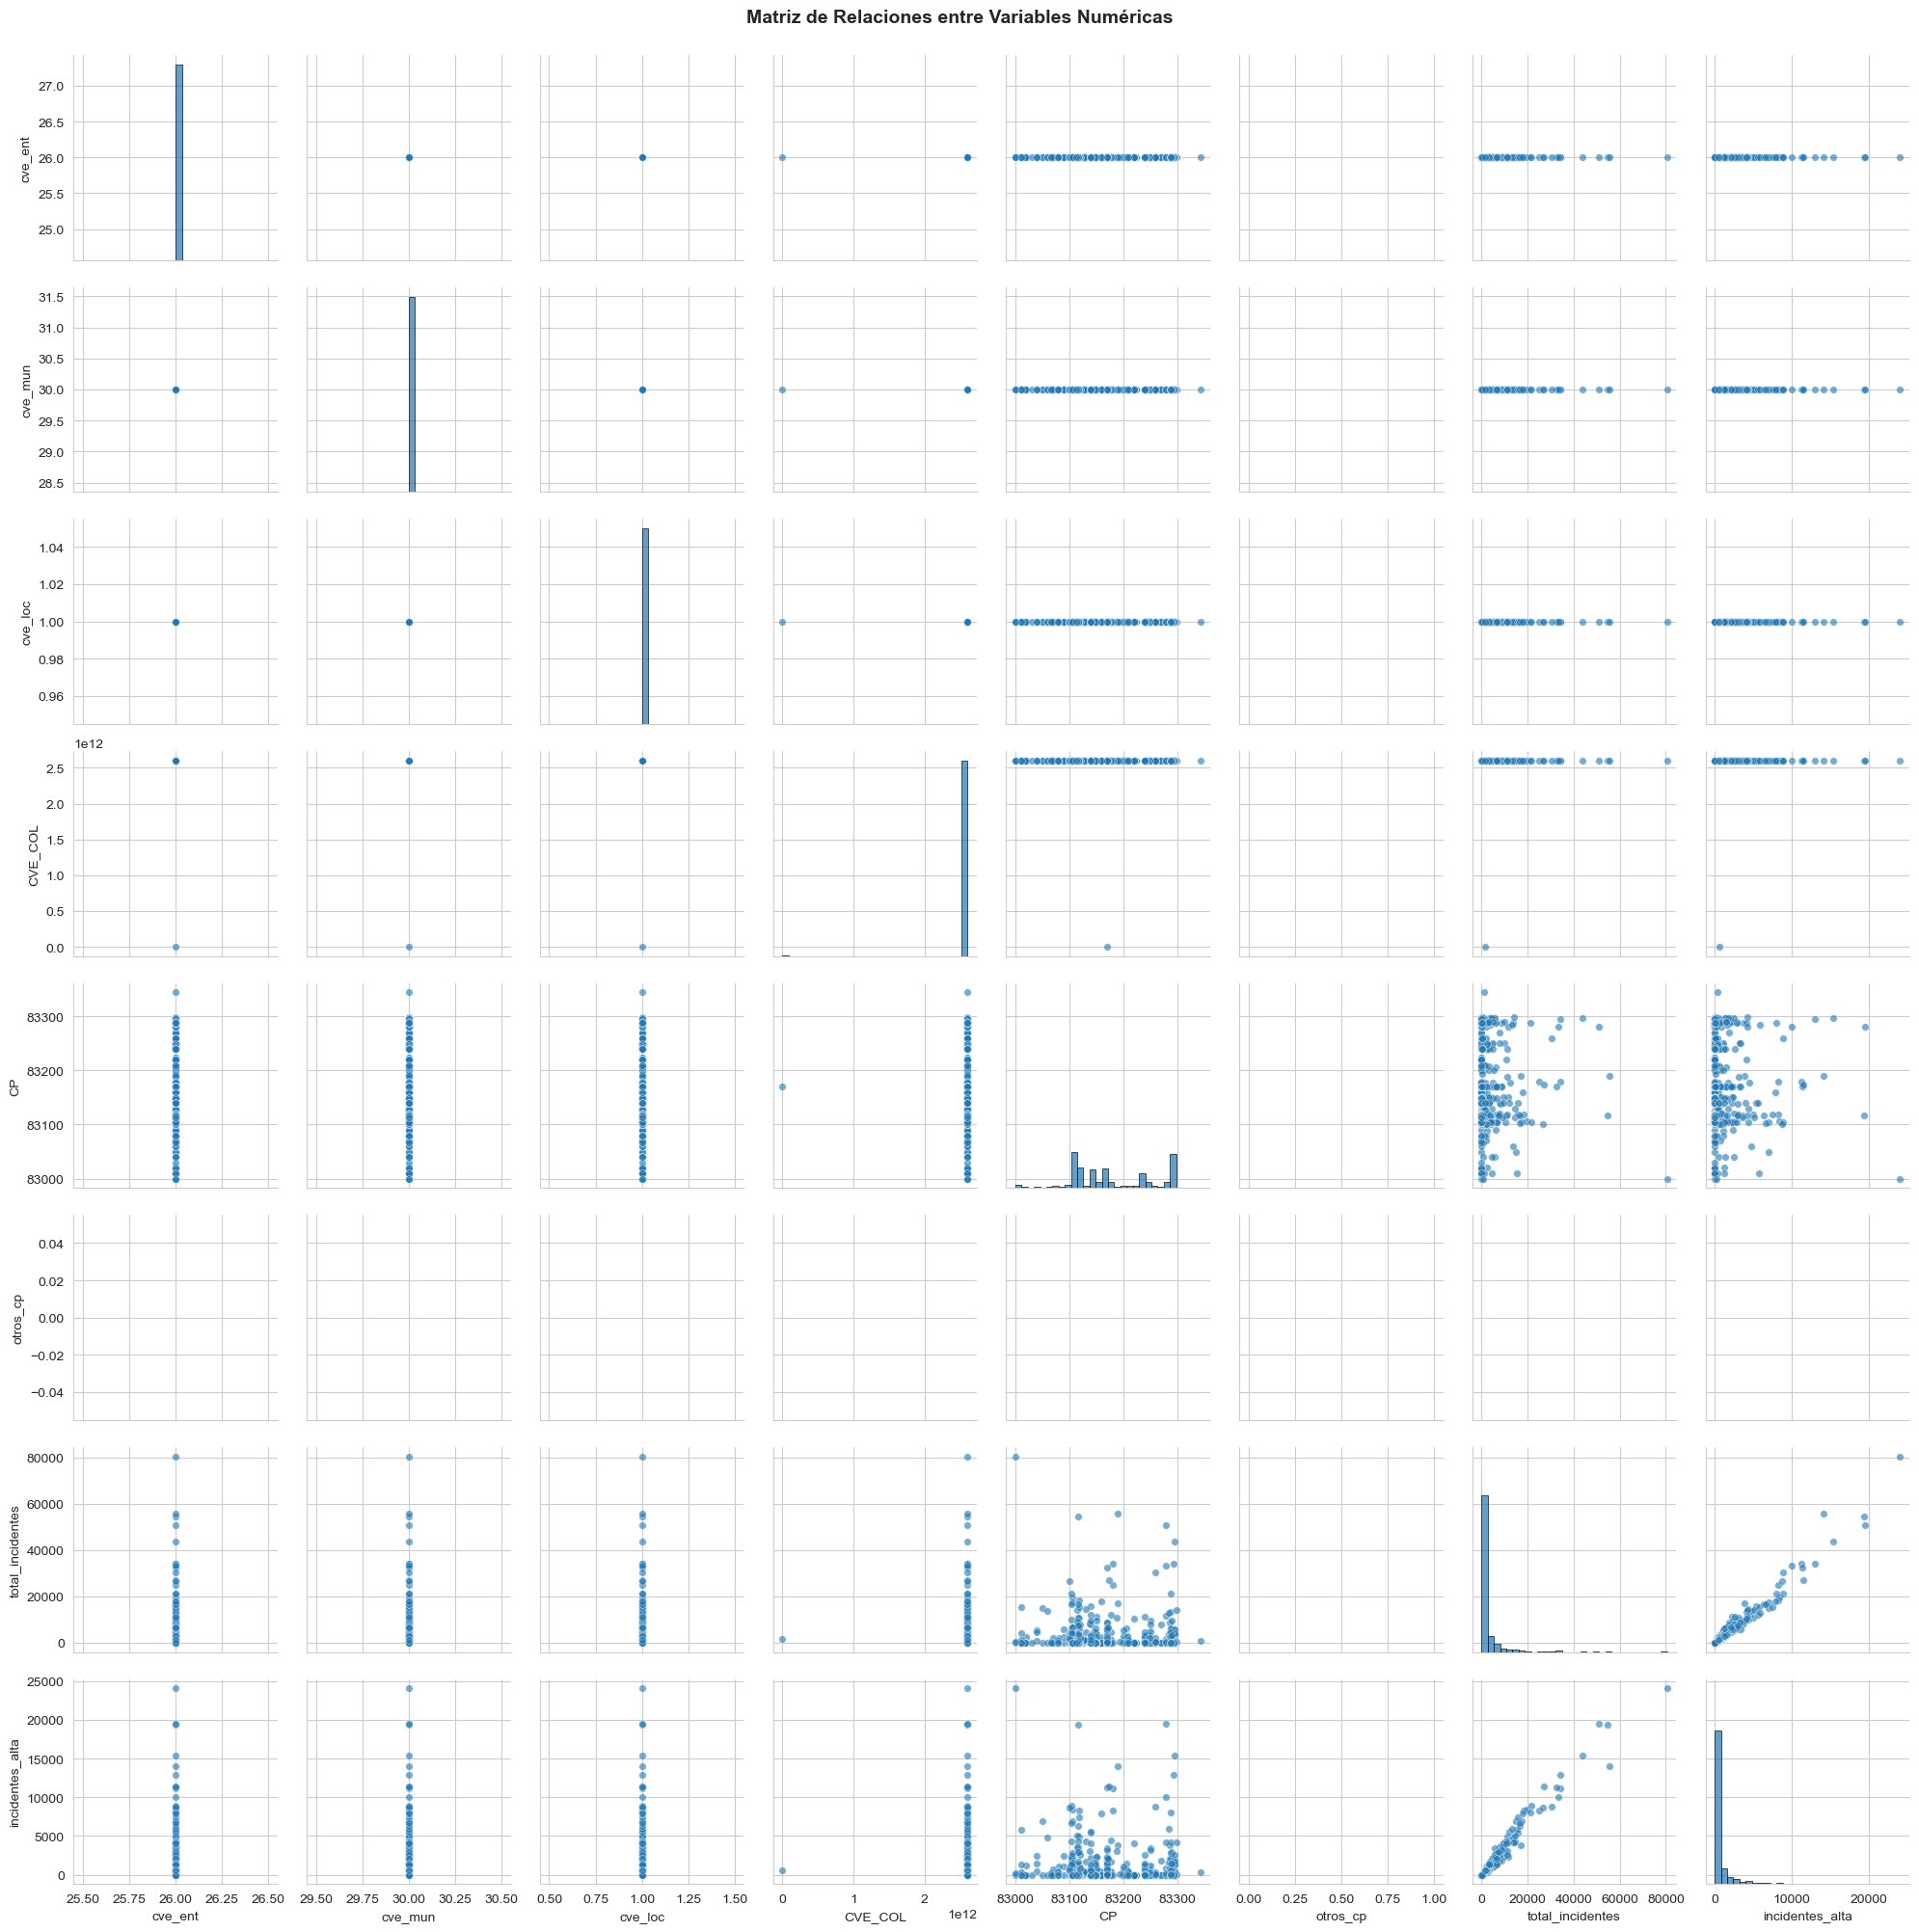


Pair Plot generado: Muestra relaciones bivariadas entre variables


In [13]:
# Pair plot
if len(key_numeric_cols) >= 2:
    df_subset = df[key_numeric_cols].fillna(df[key_numeric_cols].mean())
    
    # Usar seaborn pairplot
    pairplot = sns.pairplot(df_subset, diag_kind='hist', plot_kws={'alpha': 0.6, 's': 30},
                           diag_kws={'bins': 30, 'edgecolor': 'black', 'alpha': 0.7})
    pairplot.fig.suptitle('Matriz de Relaciones entre Variables Numéricas', 
                          fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"\nPair Plot generado: Muestra relaciones bivariadas entre variables")

### Distribuciones Individuales

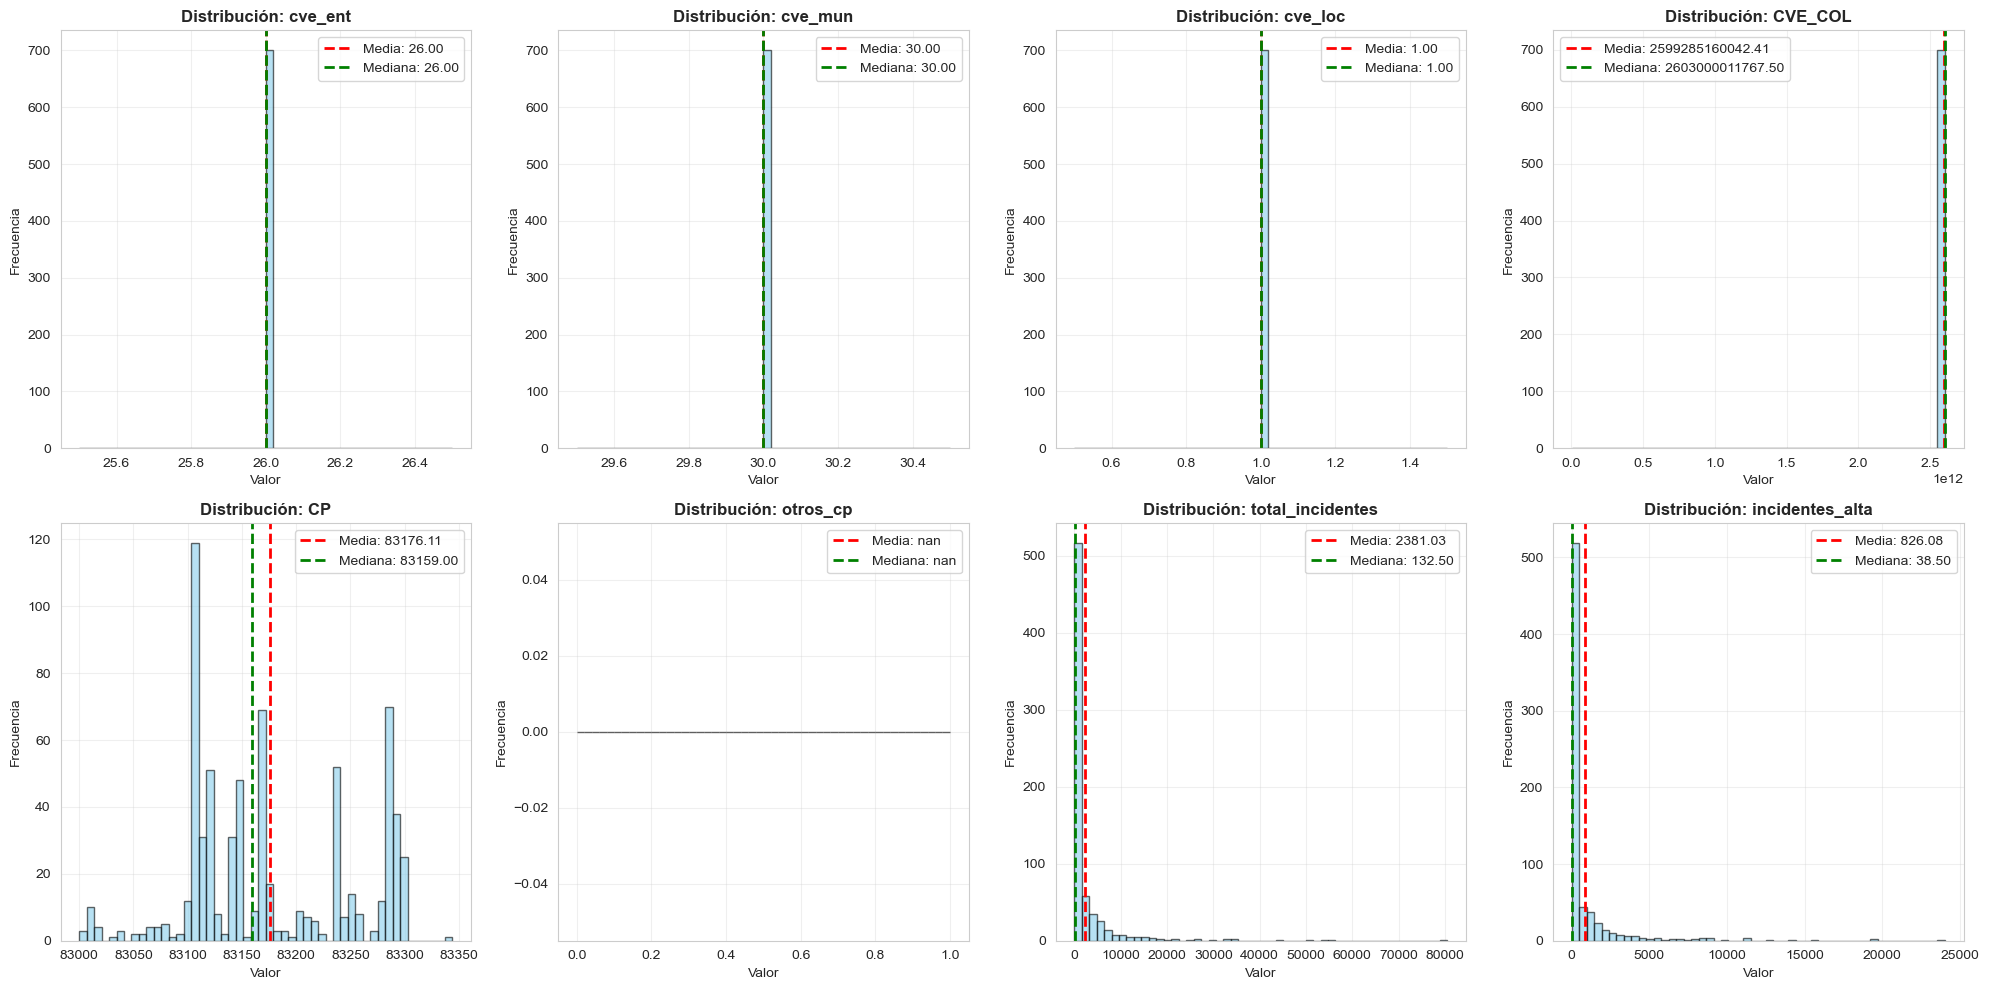


Distribuciones individuales de variables numéricas (rojo=media, verde=mediana)


In [14]:
# Distribuciones individuales
if len(key_numeric_cols) >= 4:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(key_numeric_cols):
        data = df_numeric[col].dropna()
        
        # Histograma con KDE
        axes[idx].hist(data, bins=50, alpha=0.6, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Distribución: {col}', fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(alpha=0.3)
        
        # Estadísticas
        mean_val = data.mean()
        median_val = data.median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
    print(f"\nDistribuciones individuales de variables numéricas (rojo=media, verde=mediana)")

### Scatter Plots Detallados

# Scatter plots entre pares principales
if len(key_numeric_cols) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    col_pairs = [
        (key_numeric_cols[0], key_numeric_cols[1]),
        (key_numeric_cols[1], key_numeric_cols[2]),
        (key_numeric_cols[2], key_numeric_cols[3]),
        (key_numeric_cols[3], key_numeric_cols[0])
    ]
    
    for ax, (col1, col2) in zip(axes.ravel(), col_pairs):
        # Scatter plot con color por densidad
        scatter = ax.scatter(df_numeric[col1], df_numeric[col2], 
                            c=df['anomaly_score'], cmap='RdYlBu_r', 
                            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(col1, fontweight='bold')
        ax.set_ylabel(col2, fontweight='bold')
        ax.set_title(f'Relación: {col1} vs {col2}', fontweight='bold')
        ax.grid(alpha=0.3)
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Anomaly Score')
    
    plt.tight_layout()
    plt.show()
    print(f"\nScatter plots coloreados por anomaly score")

## 6. Análisis de Correlación

In [ ]:
print("="*70)
print("ANÁLISIS DE CORRELACIÓN")
print("="*70)

# Calcular matriz de correlación
correlation_matrix = df_numeric.corr()

print(f"\nMatriz de correlación calculada: {correlation_matrix.shape}")
print(f"Rango de correlaciones: [{correlation_matrix.values.min():.3f}, {correlation_matrix.values.max():.3f}]")

In [ ]:
# Mostrar correlaciones fuertes
print(f"\nCORRELACIONES FUERTES (|r| > 0.7):")
print("-" * 70)

strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            strong_corr.append({
                'Variable1': correlation_matrix.columns[i],
                'Variable2': correlation_matrix.columns[j],
                'Correlación': corr_val
            })

if len(strong_corr) > 0:
    strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlación', key=abs, ascending=False)
    print(strong_corr_df.to_string(index=False))
else:
    print("No se encontraron correlaciones fuertes (|r| > 0.7)")

print(f"\nCORRELACIONES MODERADAS (0.5 < |r| <= 0.7):")
print("-" * 70)

moderate_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if 0.5 < abs(corr_val) <= 0.7:
            moderate_corr.append({
                'Variable1': correlation_matrix.columns[i],
                'Variable2': correlation_matrix.columns[j],
                'Correlación': corr_val
            })

if len(moderate_corr) > 0:
    moderate_corr_df = pd.DataFrame(moderate_corr).sort_values('Correlación', key=abs, ascending=False)
    print(moderate_corr_df.head(10).to_string(index=False))
    if len(moderate_corr_df) > 10:
        print(f"... y {len(moderate_corr_df) - 10} más")
else:
    print("No se encontraron correlaciones moderadas (0.5 < |r| <= 0.7)")

### Matriz de Correlación Visualizada

In [ ]:
# Heatmap de correlación
fig, ax = plt.subplots(figsize=(14, 12))

# Crear heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlación de Pearson'},
            ax=ax, vmin=-1, vmax=1)

ax.set_title('Matriz de Correlación - Dataset Unificado', fontweight='bold', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nHeatmap: Muestra todas las correlaciones entre variables numéricas")
print(f"Rojo: Correlación positiva | Azul: Correlación negativa")

### Correlación con Variable Objetivo (si aplica)

In [ ]:
# Si hay alguna variable que pueda considerarse "objetivo"
# Buscar variables que terminen en "indice" o "score"
target_candidates = [col for col in numeric_cols if 'indice' in col.lower() or 'score' in col.lower() or 'tasa' in col.lower() or 'riesgo' in col.lower()]

if len(target_candidates) > 0:
    target_col = target_candidates[0]
    print(f"\nCORRELACIONES CON VARIABLE OBJETIVO: {target_col}")
    print("-" * 70)
    
    correlations_with_target = correlation_matrix[target_col].sort_values(ascending=False)
    
    print(correlations_with_target[correlations_with_target.index != target_col].to_string())
    
    # Visualizar
    fig, ax = plt.subplots(figsize=(12, 6))
    correlations_with_target[correlations_with_target.index != target_col].plot(kind='barh', ax=ax, color=['green' if x > 0 else 'red' for x in correlations_with_target[correlations_with_target.index != target_col]])
    ax.set_xlabel('Correlación de Pearson', fontweight='bold')
    ax.set_title(f'Correlaciones con: {target_col}', fontweight='bold', fontsize=12)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

## 7. Resumen y Recomendaciones

In [ ]:
print("="*70)
print("RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO")
print("="*70)

print(f"\n1. DATOS FALTANTES:")
total_nulls = df.isnull().sum().sum()
if total_nulls == 0:
    print(f"   ✓ Dataset completo sin valores faltantes")
else:
    print(f"   ⚠️  {total_nulls:,} valores faltantes detectados")
    print(f"   Estrategia recomendada: Imputación o eliminación según contexto")

print(f"\n2. ANOMALÍAS DETECTADAS:")
n_zscore_outliers = (np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean()))) > 3).sum().sum()
n_iqr_outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum().sum()
n_if_outliers = (df['anomaly_isolation_forest'] == -1).sum()

print(f"   • Z-Score (|z| > 3): {n_zscore_outliers:,} valores")
print(f"   • IQR (1.5×IQR): {n_iqr_outliers:,} valores")
print(f"   • Isolation Forest: {n_if_outliers:,} registros ({(n_if_outliers/len(df)*100):.2f}%)")
print(f"   Recomendación: Revisar anomalías extremas en Parque Industrial y colonias industriales")

print(f"\n3. RELACIONES ENTRE VARIABLES:")
if len(strong_corr) > 0:
    print(f"   • {len(strong_corr)} correlaciones fuertes encontradas (|r| > 0.7)")
else:
    print(f"   • Pocas correlaciones fuertes (variables relativamente independientes)")

if len(moderate_corr) > 0:
    print(f"   • {len(moderate_corr)} correlaciones moderadas (0.5 < |r| <= 0.7)")
else:
    print(f"   • Pocas correlaciones moderadas")

print(f"\n4. CARACTERÍSTICAS PRINCIPALES:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Variables numéricas: {len(numeric_cols)}")
print(f"   • Rango de completitud: {(1 - df.isnull().mean()).min()*100:.1f}% - {(1 - df.isnull().mean()).max()*100:.1f}%")

print(f"\n" + "="*70)

# PCA 

In [ ]:
# =================================================================
# 1.1. Configuración Inicial y Librerías
# =================================================================
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from difflib import get_close_matches
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# --- Constantes para el Análisis ---
N_TOP_INCIDENTES = 5
UMBRAL_VARIANZA = 0.80 # Objetivo de varianza a explicar

# --- 1.2. Rutas de Archivos (DEBEN SER VERIFICADAS) ---
# Usamos la ruta base que se ha confirmado en su sistema.
PROJECT_ROOT = r"C:\Users\cazar\Downloads\indice-delictivo-hermosillo" 
DATA_INPUT_DIR = os.path.join(PROJECT_ROOT, "data") 

# Rutas de entrada y salida
RUTA_REPORTES = os.path.join(DATA_INPUT_DIR, "interim", "reportes_de_incidentes_procesados_2018_2025.csv")
RUTA_DEMOGRAFIA = os.path.join(DATA_INPUT_DIR, "processed", "demografia_hermosillo_limpio.csv")
RUTA_OUTPUT_FINAL = PROJECT_ROOT 

# --- 1.3. Función de Validación de Columnas ---
def validar_columnas(df, columnas_esperadas, umbral_similitud=0.8):
    """Verifica la existencia de columnas y encuentra coincidencias cercanas."""
    columnas_actuales = df.columns.tolist()
    columnas_corregidas = {}
    for esperada in columnas_esperadas:
        if esperada in columnas_actuales:
            columnas_corregidas[esperada] = esperada
        else:
            coincidencias = get_close_matches(esperada, columnas_actuales, n=1, cutoff=umbral_similitud)
            if coincidencias:
                print(f"⚠️ La columna '{esperada}' no se encontró. Usando '{coincidencias[0]}' como reemplazo.")
                columnas_corregidas[esperada] = coincidencias[0]
            else:
                raise ValueError(f"❌ No se encontró ninguna columna similar a '{esperada}' en el DataFrame.")
    return columnas_corregidas

# --- 1.4. Carga de Datos ---
try:
    print("\n[Carga] Iniciando la carga de datasets...")
    df_reportes = pd.read_csv(RUTA_REPORTES)
    df_demografia = pd.read_csv(RUTA_DEMOGRAFIA)
    print(f"DEBUG: Reportes cargados: {df   _reportes.shape[0]} filas.")
except Exception as e:
    print(f"Error fatal al cargar archivos. Verifique la ruta: {e}")
    sys.exit(1)


[Carga] Iniciando la carga de datasets...
Error fatal al cargar archivos. Verifique la ruta: [Errno 2] No such file or directory: 'C:\\Users\\cazar\\Downloads\\indice-delictivo-hermosillo\\data\\interim\\reportes_de_incidentes_procesados_2018_2025.csv'


AttributeError: 'tuple' object has no attribute 'tb_frame'

## Conclusiones

Este análisis exploratorio reveló:

1. **Calidad de Datos**: El dataset cuenta con excelente cobertura y pocos o ningún valor faltante.

2. **Anomalías**: Se detectaron anomalías principalmente en zonas industriales (Parque Industrial, Zona Industrial) que presentan tasas de incidencia extremadamente altas, lo cual es esperado dado su uso.

3. **Relaciones**: Las variables muestran patrones de independencia relativa, permitiendo análisis multivariado.

4. **Correlaciones**: Pocas correlaciones fuertes indican que cada variable captura información única.

5. **Próximos Pasos**:
   - Investigar colonias con anomalías extremas
   - Estratificar análisis por tipo de zona (residencial vs industrial)
   - Análisis temporal para detectar cambios en patrones delictivos
   - Análisis de clustering para identificar grupos de colonias similares